Mona Mokart & Paule Grangette - Time Series Project

# PART 2 - Analyses on SKAB & Synthesized datasets 

**Preferably to be run on GoogleColab**

This notebook shows the analyses of the soccercpd method on the SKAB dataset and the synthesized dataset. The prediction of the change-points can be long (5 min for 20 matches for one method), so if you just want to run the analysis cells you have to download the data at this link : https://drive.google.com/drive/folders/1uuFoFAW11klWIQNfn6-uI8SwrrJgIemq?usp=share_link

Then you can run only the cells that contain : ```# /!\ MANDATORY```


In [1]:
save_dir = "/content/drive/MyDrive/soccercpd/MVAdata"  # to change and complete (use the folder where you saved the downloaded data)

In [2]:
!pip install rpy2==3.4.5
!pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.4.5-cp39-cp39-linux_x86_64.whl size=297791 sha256=180f3e086c8d6f49fde31f23021c3861d01720f66ddf05a4750edc92d9d058bb
  Stored in directory: /root/.cache/pip/wheels/36/d1/63/882c1f63d21bcf817b7db960b9536a747d4258daeaace0edd4
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.2 MB/s eta 0:00:00


In [3]:
# /!\ MANDATORY
import os
import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings('ignore')

import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import rpy2.rinterface_lib.embedded as rembedded

from sklearn.metrics import pairwise_distances
import ruptures as rpt
from tqdm import tqdm
import networkx as nx

#Change-point-detection (CPD) & useful functions

## CPD function (like soccercpd):

In [4]:
l2 = lambda mat1, mat2 : np.sqrt(np.square(mat1 - mat2).sum())
manhattan = lambda mat1, mat2 : np.abs(mat1 - mat2).sum() 
hamming = lambda perm1, perm2 : (perm1 != perm2).astype(int).sum()

def like_soccercp(input_seq, tempdir="tmp", mode="gseg_avg", max_pval=0.01, min_pdur=30, metric=l2 ,min_dist=4):
  utils = rpackages.importr('utils')
  utils.chooseCRANmirror(ind=1)
  if not rpackages.isinstalled('gSeg'):
    utils.install_packages('gSeg')
    rpackages.importr('gSeg')
    
  start_time = input_seq.index[0].time()
  end_time = input_seq.index[-1].time()
  dists = pd.DataFrame(pairwise_distances(input_seq.drop_duplicates(), metric=metric))

  if not os.path.exists(tempdir):
    os.mkdir(tempdir)
  input_seq.to_csv(f'{tempdir}/temp_seq.csv', index=False)
  dists.to_csv(f'{tempdir}/temp_dists.csv', index=False)

  if "gseg" in mode:
    gseg_type = mode.split("_")[1][0]
    try:
      #print(f"Applying g-segmentation to the sequence between {start_time} and {end_time}...")
      robjects.r(f'''
                      dir = '{tempdir}'
                      seq_path = paste(dir, 'temp_seq.csv', sep='/')
                      seq = read.csv(seq_path)
                      dists_path = paste(dir, 'temp_dists.csv', sep='/')
                      dists = read.csv(dists_path)
                      n = dim(seq)[1]
                      edge_mat = nnl(dists, 1)
                      seq_str = do.call(paste, seq)
                      ids = match(seq_str, unique(seq_str))
                      output = gseg1_discrete(n, edge_mat, ids, statistics='generalized', n0=0.1*n, n1=0.9*n)
                      
                      chg_idx = output$scanZ$generalized$tauhat_{gseg_type}
                      pval = output$pval.appr$generalized_{gseg_type}
                  ''')
    except rembedded.RRuntimeError:
      return []
  
    if robjects.r['pval'][0] >= max_pval:
      #print('Change-point insignificant: The p-value is not small enough.\n')
      return []

    else:
      chg_idx = robjects.r['chg_idx'][0]

  elif 'kernel' in mode:
            #print(f"Applying kernel-based CPD to the sequence between {start_time} and {end_time}...")
            kernel_type = mode.split('_')[1]
            algo = rpt.Binseg(model=kernel_type).fit(input_seq.values)
            chg_idx = algo.predict(n_bkps=1)[0]
        
  elif 'rank' in mode:
      #print(f"Applying rank-based CPD to the sequence between {start_time} and {end_time}...")
      algo = rpt.Binseg(model='rank').fit(input_seq.values)
      chg_idx = algo.predict(n_bkps=1)[0]
      
  elif 'window' in mode :
      algo = rpt.Window(width=40, model="rbf").fit(input_seq.values)
      chg_idx = algo.predict(n_bkps=1)[0]

  elif 'Pelt' in mode:
    algo = rpt.Pelt(model="rbf", min_size=min_pdur, jump=5).fit(input_seq.values)
    chg_idx = algo.predict(pen=3)
    chg_dt = input_seq.index[chg_idx]
    return chg_dt


  chg_dt = input_seq.index[chg_idx]
  seq1 = input_seq[:chg_dt]
  seq2 = input_seq[chg_dt:]

  form1_edge_mat = seq1.mean(axis=0).values
  form2_edge_mat = seq2.mean(axis=0).values
  if metric(form1_edge_mat, form2_edge_mat) < min_dist:
      #print('Change-point insignificant: The formation is not changed.\n')
      return []

  if (len(seq1) < min_pdur) or (len(seq2) < min_pdur):
    #print('Change-point insignificant: One of the periods has not enough duration.\n')
    return []

  #print(f'A significant fine-tuned change-point at {chg_dt.time()}.\n')
  prev_chg_dts = like_soccercp(seq1, tempdir=tempdir, mode=mode, max_pval=max_pval)
  next_chg_dts = like_soccercp(seq2, tempdir=tempdir, mode=mode, max_pval=max_pval)
  return prev_chg_dts + [chg_dt] + next_chg_dts





## Useful functions : 

In [5]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [6]:
def preprocess(data, pp_type):
  gt = data[data.columns[-2:]]
  seq = data[data.columns[:-2]]
  if pp_type == "normalize":
    eq = (seq - seq.mean(axis=0))/seq.std(axis=0)

  elif pp_type == "bins":
    for col in seq.columns:
      counts, bins = np.histogram(seq[col], bins=10)
      seq[col] = inds = np.digitize(seq[col], bins)
  return seq, gt

## Evaluation functions : 

In [7]:
# /!\ MANDATORY
# found evaluations metrics here : https://charles.doffy.net/files/sp-review-2020.pdf 
def directed_hausdorff(u, v):
  min_values = []
  for i in u:
    dist = [abs(i - j) for j in v]
    min_dist = min(dist)
    min_values.append(min_dist)
  return max(min_values)

def hausdorff(gt, pred):
  if not gt or not pred:
    return np.nan
  return max(directed_hausdorff(gt, pred), directed_hausdorff(pred, gt)).seconds

def f1score(gt, pred, M=15):
  if not gt and not pred:
    return {"precision": np.nan, "recall": np.nan, "f1": np.nan}
  TP = 0
  for t_star in gt:
    for t_hat in pred:
      if np.abs(t_star - t_hat).seconds <= M:
        TP += 1
        break
  precision = TP / (len(pred) + 1e-12)
  recall = TP / (len(gt) + 1e-12)
  f1 = 2 * precision * recall / (precision + recall +1e-12)
  return {"precision": precision, "recall": recall, "f1": f1}

In [8]:
# /!\ MANDATORY
def results_analysis(total_pred, total_gt):
  total_f1 = []
  total_hausdorff = []
  for cp_pred, cp_gt in zip(total_pred, total_gt):
    total_f1.append(f1score(cp_gt, cp_pred)["f1"])
    total_hausdorff.append(hausdorff(cp_gt, cp_pred))

  print(f"f1 avg : {np.nanmean(total_f1)}")
  print(f"hausdorff avg : {np.nanmean(total_hausdorff)} sec")

# SKAB dataset

## Get dataset 

In [9]:
!git clone https://github.com/waico/SKAB.git

Cloning into 'SKAB'...
remote: Enumerating objects: 809, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 809 (delta 105), reused 49 (delta 49), pack-reused 686
Receiving objects: 100% (809/809), 25.17 MiB | 28.38 MiB/s, done.
Resolving deltas: 100% (500/500), done.


In [10]:
all_files = []
for root, dirs, files in os.walk("SKAB/data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(f'{root}/{file}')
all_files.sort()

valve1_data = {file.split('/')[-1]: pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file
               in all_files if 'valve1' in file}

In [11]:
print('Dataset size:', valve1_data['1.csv'].shape)
valve1_data['1.csv'].head(3)

Dataset size: (1145, 10)


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:34:33,0.027080,0.039615,0.871339,0.054711,75.4955,25.8338,244.091,32.0000,0.0,0.0
2020-03-09 10:34:34,0.026995,0.038759,1.301280,0.054711,75.5445,25.8408,224.170,32.0000,0.0,0.0
2020-03-09 10:34:35,0.026807,0.039521,1.284500,0.382638,75.6607,25.8227,234.157,32.9986,0.0,0.0


In [12]:
data1_discrete, gt = preprocess(valve1_data['1.csv'], "bins")
data1_discrete.head(3)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 10:34:33,6,2,5,6,9,8,8,7
2020-03-09 10:34:34,6,1,8,6,9,8,5,7
2020-03-09 10:34:35,5,2,8,7,9,7,6,10


## CPD on SKAB

In [13]:
# /!\ MANDATORY
sub_dir_skab = f"{save_dir}/SKAB"
if not os.path.exists(sub_dir_skab):
  os.makedirs(sub_dir_skab)

In [15]:
cpd_modes = ['gseg_avg', 'gseg_union', 'kernel_linear', 'kernel_rbf', 'kernel_cosine', 'rank']
for mode in cpd_modes:
  total_pred = []
  total_gt = []
  with HiddenPrints():
    for name, data in tqdm(valve1_data.items()):
      seq, gt = preprocess(data, "bins")
      cp_pred = like_soccercp(seq, metric=manhattan, mode=mode)
      cp_gt = gt[gt["changepoint"] == 1].index.tolist()
      total_pred.append(cp_pred)
      total_gt.append(cp_gt)

  (pd.DataFrame([total_pred, total_gt],
                columns=valve1_data.keys(),
                index=["pred", "gt"]).T).to_pickle(f"{sub_dir_skab}/valve1_{mode}.pkl")

100%|██████████| 16/16 [06:48<00:00, 25.53s/it]


In [16]:
# /!\ MANDATORY
cdp_modes = ['gseg_avg', 'gseg_union', 'kernel_linear', 'kernel_rbf', 'kernel_cosine', 'rank']
for mode in cdp_modes:
  print("\nChange-point-detection algo : {}".format(mode))
  results = pd.read_pickle(f"{sub_dir_skab}/valve1_{mode}.pkl")
  total_gt = results["gt"]
  total_pred = results["pred"]
  results_analysis(total_pred, total_gt)



Change-point-detection algo : gseg_avg
f1 avg : 0.46681547618993213
hausdorff avg : 221.125 sec

Change-point-detection algo : gseg_union
f1 avg : 0.46681547618993213
hausdorff avg : 221.125 sec

Change-point-detection algo : kernel_linear
f1 avg : 0.12767857142839012
hausdorff avg : 360.875 sec

Change-point-detection algo : kernel_rbf
f1 avg : 0.39975198412645896
hausdorff avg : 216.875 sec

Change-point-detection algo : kernel_cosine
f1 avg : 0.3163194444439491
hausdorff avg : 237.6875 sec

Change-point-detection algo : rank
f1 avg : 0.4004960317455311
hausdorff avg : 230.8125 sec


# Synthesized dataset

In [ ]:
# /!\ MANDATORY
sub_dir_fake = f"{save_dir}/invented_dataset"
if not os.path.exists(sub_dir_fake):
  os.makedirs(sub_dir_fake)

In [ ]:
!git clone https://github.com/monamokart/soccercpd.git

Cloning into 'soccercpd'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 101 (delta 41), reused 86 (delta 26), pack-reused 0
Receiving objects: 100% (101/101), 18.80 MiB | 20.88 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/soccercpd


In [ ]:
form_periods = pd.read_pickle(f'soccercpd/data/form_periods.pkl')
form_periods

,activity_id,session,form_period,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,12864,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-719.0, 1625.0], [-1342.0, 660.0], [948.0, 1...","[[0.0, 0.977, 0.955, 0.2, 0.023, 0.828, 0.257,...",20,442
1,12868,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-833.0, -1647.0], [14.0, 181.0], [-369.0, -1...","[[0.0, 0.338, 0.684, 0.994, 0.165, 0.042, 0.15...",5,4132
2,12868,2,2,2020-01-01 15:02:00,2020-01-01 15:50:00,2880.0,"[[-933.0, -1939.0], [-106.0, 618.0], [-231.0, ...","[[0.0, 0.164, 0.86, 0.993, 0.131, 0.036, 0.237...",20,442
3,12870,1,1,2020-01-01 13:30:00,2020-01-01 14:19:00,2940.0,"[[-1408.0, 43.0], [460.0, -1087.0], [-285.0, 5...","[[0.0, 0.22, 0.871, 0.098, 0.367, 0.962, 0.328...",12,352
4,12870,2,2,2020-01-01 14:33:00,2020-01-01 15:23:00,3000.0,"[[-1282.0, -147.0], [290.0, -888.0], [-209.0, ...","[[0.0, 0.416, 0.886, 0.054, 0.192, 0.998, 0.27...",-1,others
...,...,...,...,...,...,...,...,...,...,...
861,9064,2,3,2020-01-01 16:32:00,2020-01-01 16:51:00,1140.0,"[[-1589.0, 486.0], [-1684.0, -710.0], [-34.0, ...","[[0.0, 0.984, 0.515, 0.04, 0.009, 0.025, 0.813...",20,442
862,9281,1,1,2020-01-01 15:00:00,2020-01-01 15:47:00,2820.0,"[[-1478.0, 113.0], [-1176.0, -1051.0], [1666.0...","[[0.0, 0.982, 0.015, 0.022, 0.016, 0.191, 0.98...",0,343
863,9281,2,2,2020-01-01 16:03:00,2020-01-01 16:51:00,2880.0,"[[-1270.0, -89.0], [-1128.0, -1051.0], [1465.0...","[[0.0, 0.94, 0.052, 0.025, 0.047, 0.184, 0.974...",20,442
864,9285,1,1,2020-01-01 14:01:00,2020-01-01 14:48:00,2820.0,"[[-674.0, 1815.0], [-1457.0, 614.0], [-1564.0,...","[[0.0, 0.992, 0.237, 0.295, 0.148, 0.748, 0.20...",18,4231


## Dataset creation

In [ ]:
# /!\ MANDATORY
activity_ids = [14933,  8557, 22875, 17375,  6736,  6652, 16980,  6145,
            17304, 17681,  5472,  6859,  5428, 17692,  5090, 18630,  4892,
            16514, 15849, 16150]

In [ ]:
# Dataset creation

dataset = []
for id in activity_ids:
  values = form_periods[form_periods['activity_id'] == id]

  changepoints = []
  times = []
  edge_values = []
  sessions = []
  coords = []
  edge_probs = []

  formation_before = 1
  session_before = 1

  for i in values.index:
    row = values.loc[i]

    start_dt = row["start_dt"]
    end_dt = row["end_dt"]
    session_now = row["session"]
    formation_now = row["form_period"]

    total_sec = (end_dt - start_dt).seconds
    adj_prob = np.tril(row["edge_mat"])
    
    for sec in range(0, total_sec, 5):
      adj_mat = (adj_prob > np.random.rand(*adj_prob.shape)).astype(int)
      adj_mat = adj_mat + adj_mat.T
      changepoint = int(formation_now != formation_before and session_now == session_before)
      
      changepoints.append(changepoint)
      edge_values.append(adj_mat.flatten())
      sessions.append(session_now)
      times.append(start_dt + datetime.timedelta(seconds=sec))
      coords.append(row["coords"])
      edge_probs.append(row["edge_mat"])

      formation_before = formation_now
      session_before = session_now


  df = pd.DataFrame(edge_values, index=times)
  df["changepoint"] = changepoints
  df["session"] = sessions
  df["coords"] = coords
  df["edge_probs"] = edge_probs
  dataset.append(df)

for i, data in zip(activity_ids, dataset):
  data.to_pickle(f"{sub_dir_fake}/dataset_{i}.pkl")

In [ ]:
# /!\ MANDATORY
dataset = []
for i in activity_ids:
  dataset.append(pd.read_pickle(f"{sub_dir_fake}/dataset_{i}.pkl"))

## CPD on the fake dataset

In [ ]:
def cpd_on_fake_dataset(dataset, mode, metric=manhattan, min_pdur=60, min_dist=7, max_pval=0.01):
  total_pred = []
  total_gt = []
  columns = []
  with HiddenPrints():
    for i in tqdm(range(len(dataset))):
      data = dataset[i]
      id = activity_ids[i]

      for session in data["session"].unique():
        columns.append(f"{id}_{session}")
        data_session = data[data["session"] == session]
        seq = data_session[data_session.columns[:-4]]
        gt = data_session[["changepoint"]]

        cp_pred = like_soccercp(seq, metric=manhattan, mode=mode, min_pdur=min_pdur, min_dist=min_dist, max_pval=max_pval)
        cp_gt = gt[gt["changepoint"] == 1].index.tolist()
        total_pred.append(cp_pred)
        total_gt.append(cp_gt)
        
    return total_pred, total_gt, columns

In [ ]:
cpd_modes = ['gseg_avg', 'gseg_union', 'kernel_linear', 'kernel_rbf', 'kernel_cosine', 'rank', 'window']
for mode in cpd_modes:
  total_pred, total_gt, columns = cpd_on_fake_dataset(dataset, mode)
  (pd.DataFrame([total_pred, total_gt],
                  columns=columns,
                  index=["pred", "gt"]).T).to_pickle(f"{sub_dir_fake}/{mode}.pkl")

  0%|          | 0/20 [00:00<?, ?it/s]WARNING:rpy2.rinterface_lib.callbacks:R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)







	‘/tmp/Rtmp2AhTXo/downloaded_packages’

100%|██████████| 20/20 [03:30<00:00, 10.51s/it]


In [ ]:
# /!\ MANDATORY
cpd_modes = ['gseg_avg', 'gseg_union', 'kernel_linear', 'kernel_rbf', 'kernel_cosine', 'rank', 'window']
for mode in cpd_modes:
  print("\nChange-point-detection algo : {}".format(mode))
  results = pd.read_pickle(f"{sub_dir_fake}/{mode}.pkl")
  total_gt = results["gt"]
  total_pred = results["pred"]
  results_analysis(total_pred, total_gt)



Change-point-detection algo : gseg_avg
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Change-point-detection algo : gseg_union
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Change-point-detection algo : kernel_linear
f1 avg : 0.0
hausdorff avg : nan sec

Change-point-detection algo : kernel_rbf
f1 avg : 0.7727272727261135
hausdorff avg : 8.25 sec

Change-point-detection algo : kernel_cosine
f1 avg : 0.8181818181805909
hausdorff avg : 7.0 sec

Change-point-detection algo : rank
f1 avg : 0.8636363636350682
hausdorff avg : 5.75 sec

Change-point-detection algo : window
f1 avg : 0.7272727272716363
hausdorff avg : 7.222222222222222 sec


## Influence of `min_dist`

In [ ]:
dist_list = [5, 6, 7, 8, 9, 10]
mode = "gseg_avg"

for min_dist  in dist_list:
  total_pred, total_gt, columns = cpd_on_fake_dataset(dataset, mode, min_dist=min_dist)
  (pd.DataFrame([total_pred, total_gt],
                columns=columns,
                index=["pred", "gt"]).T).to_pickle(f"{sub_dir_fake}/{mode}_min{min_dist}.pkl")

100%|██████████| 20/20 [02:43<00:00,  8.20s/it]


In [ ]:
# /!\ MANDATORY
dist_list = [5, 6, 7, 8, 9, 10]
mode = "gseg_avg"

for min_dist  in dist_list:
  print("\nMin distance between the two new sequences : {}".format(min_dist))
  results = pd.read_pickle(f"{sub_dir_fake}/{mode}_min{min_dist}.pkl")
  total_gt = results["gt"]
  total_pred = results["pred"]
  results_analysis(total_pred, total_gt)


Min distance between the two new sequences : 5
f1 avg : 0.6363636363626818
hausdorff avg : 15.909090909090908 sec

Min distance between the two new sequences : 6
f1 avg : 0.6363636363626818
hausdorff avg : 15.714285714285714 sec

Min distance between the two new sequences : 7
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Min distance between the two new sequences : 8
f1 avg : 0.5454545454537272
hausdorff avg : 6.428571428571429 sec

Min distance between the two new sequences : 9
f1 avg : 0.22727272727238634
hausdorff avg : 2.0 sec

Min distance between the two new sequences : 10
f1 avg : 0.18181818181790907
hausdorff avg : 0.0 sec


## Influence of `min_pdur`

In [ ]:
data_by_min = 12
pdur_list = np.array([0.5, 1, 2, 3, 4, 5, 6, 7, 10]) * data_by_min  # number of min * data_by_min
mode = "gseg_avg"

for min_pdur in pdur_list:
  total_pred, total_gt, columns = cpd_on_fake_dataset(dataset, mode, min_pdur=min_pdur)
  (pd.DataFrame([total_pred, total_gt],
                columns=columns,
                index=["pred", "gt"]).T).to_pickle(f"{sub_dir_fake}/{mode}_dur{int(min_pdur)}.pkl")

100%|██████████| 20/20 [02:56<00:00,  8.80s/it]


In [ ]:
# /!\ MANDATORY
data_by_min = 12
pdur_list = np.array([0.5, 1, 2, 3, 4, 5, 6, 7, 10]) * data_by_min  # number of min * data_by_min
mode = "gseg_avg"

for min_pdur  in pdur_list:
  print("\nMin duration of new sequences : {}".format(min_pdur))
  results = pd.read_pickle(f"{sub_dir_fake}/{mode}_dur{int(min_pdur)}.pkl")
  total_gt = results["gt"]
  total_pred = results["pred"]
  results_analysis(total_pred, total_gt)


Min duration of new sequences : 6.0
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Min duration of new sequences : 12.0
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Min duration of new sequences : 24.0
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Min duration of new sequences : 36.0
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Min duration of new sequences : 48.0
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Min duration of new sequences : 60.0
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Min duration of new sequences : 72.0
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Min duration of new sequences : 84.0
f1 avg : 0.5909090909082045
hausdorff avg : 10.555555555555555 sec

Min duration of new sequences : 120.0
f1 avg : 0.22727272727238634
hausdorff avg : 12.5 sec


## Influence of `max_pval`

In [ ]:
pval_list = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
mode = "gseg_avg"

for max_pval in pval_list:
  total_pred, total_gt, columns = cpd_on_fake_dataset(dataset, mode, max_pval=max_pval)
  (pd.DataFrame([total_pred, total_gt],
                columns=columns,
                index=["pred", "gt"]).T).to_pickle(f"{sub_dir_fake}/{mode}_pval{max_pval}.pkl")

100%|██████████| 20/20 [03:56<00:00, 11.83s/it]


In [ ]:
# /!\ MANDATORY
pval_list = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
mode = "gseg_avg"

for max_pval in pval_list:
  print("\nMaximuum p-value : {}".format(max_pval))
  results = pd.read_pickle(f"{sub_dir_fake}/{mode}_pval{max_pval}.pkl")
  total_gt = results["gt"]
  total_pred = results["pred"]
  results_analysis(total_pred, total_gt)


Maximuum p-value : 0.5
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Maximuum p-value : 0.1
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Maximuum p-value : 0.05
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Maximuum p-value : 0.01
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Maximuum p-value : 0.005
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec

Maximuum p-value : 0.001
f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec


## l2 distance

In [ ]:
total_pred, total_gt, columns = cpd_on_fake_dataset(dataset, mode="gseg_avg", metric=l2 )
results_analysis(total_pred, total_gt)

100%|██████████| 20/20 [04:04<00:00, 12.23s/it]

f1 avg : 0.6363636363626818
hausdorff avg : 10.0 sec


## Visualization of the invented graph

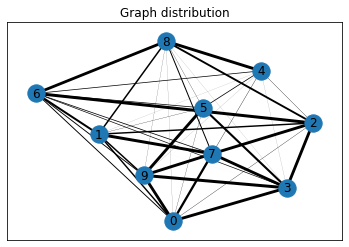

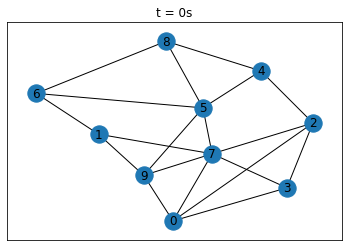

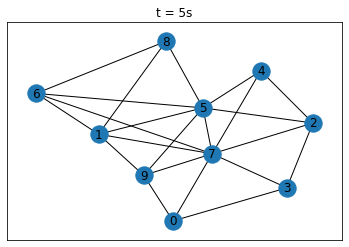

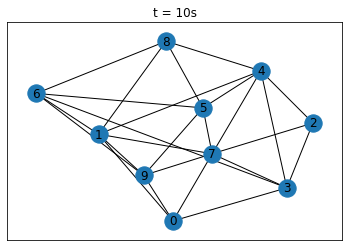

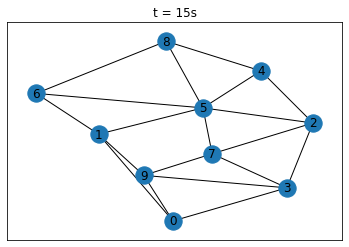

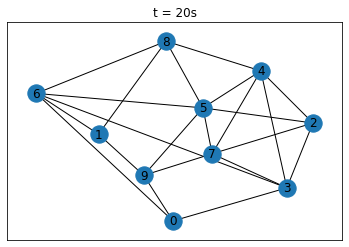

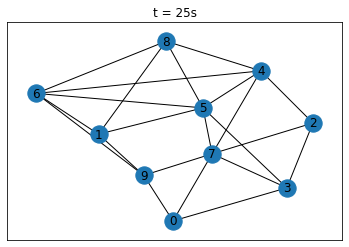

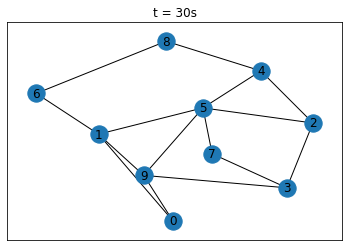

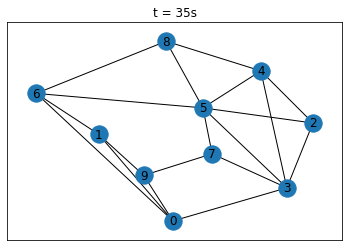

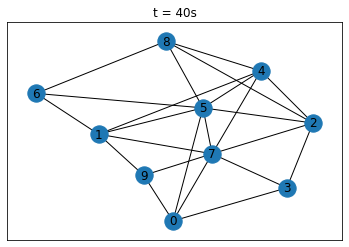

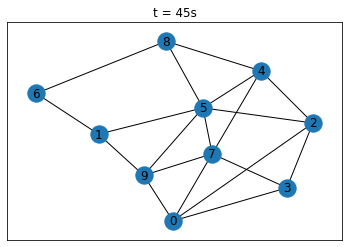

In [ ]:
match_1 = dataset[0]
positions = match_1.iloc[0]["coords"]
adj_matrix = match_1.iloc[0]["edge_probs"]
edgesx, edgesy = np.nonzero(adj_matrix)
weights = adj_matrix[edgesx, edgesy]
edges = np.concatenate([edgesx.reshape(-1, 1), edgesy.reshape(-1, 1)], axis=1)

plt.figure()
G = nx.Graph()
G.add_edges_from(edges)
nx.draw_networkx(G, positions, width=weights*3)
plt.title("Graph distribution")


for i in range(10):
  plt.figure()
  adj_matrix = match_1.iloc[i][:-4].values.reshape((10, 10))
  edgesx, edgesy = np.nonzero(adj_matrix)
  edges = np.concatenate([edgesx.reshape(-1, 1), edgesy.reshape(-1, 1)], axis=1)
  G = nx.Graph()
  G.add_edges_from(edges)
  nx.draw_networkx(G, positions,  with_labels = True)
  plt.title(f"t = {i * 5}s")
plt.show()